In [1]:
!pip install torch torchvision torchattacks


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [10]:
batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


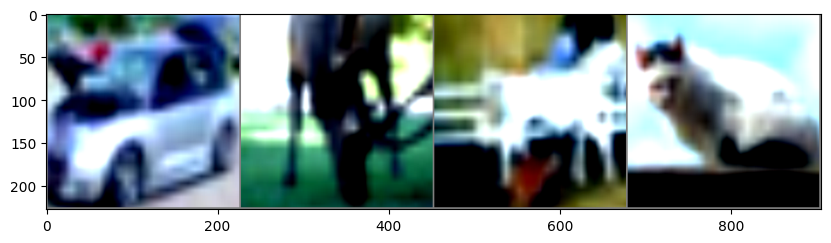

car deer horse cat


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 5))
imshow(torchvision.utils.make_grid(images[:4]))
plt.show()
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))


In [12]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(512, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
num_epochs = 2

subset_size = 5000
train_subset, _ = torch.utils.data.random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1/2, Loss: 1.0744, Train Accuracy: 0.6288, Val Accuracy: 0.6793
Epoch 2/2, Loss: 0.5901, Train Accuracy: 0.7976, Val Accuracy: 0.7354


In [15]:
torch.save(model.state_dict(), 'resnet18_cifar10.pth')


In [16]:
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')


Accuracy of the network on the 10000 test images: 73.54 %


In [18]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Ensure images are on the correct device
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname] if total_pred[classname] > 0 else 0
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 79.0 %
Accuracy for class: car   is 73.2 %
Accuracy for class: bird  is 40.5 %
Accuracy for class: cat   is 48.0 %
Accuracy for class: deer  is 72.6 %
Accuracy for class: dog   is 74.0 %
Accuracy for class: frog  is 92.6 %
Accuracy for class: horse is 82.2 %
Accuracy for class: ship  is 77.6 %
Accuracy for class: truck is 95.7 %


**FGSM Attack**

Success Rate: 0.5062


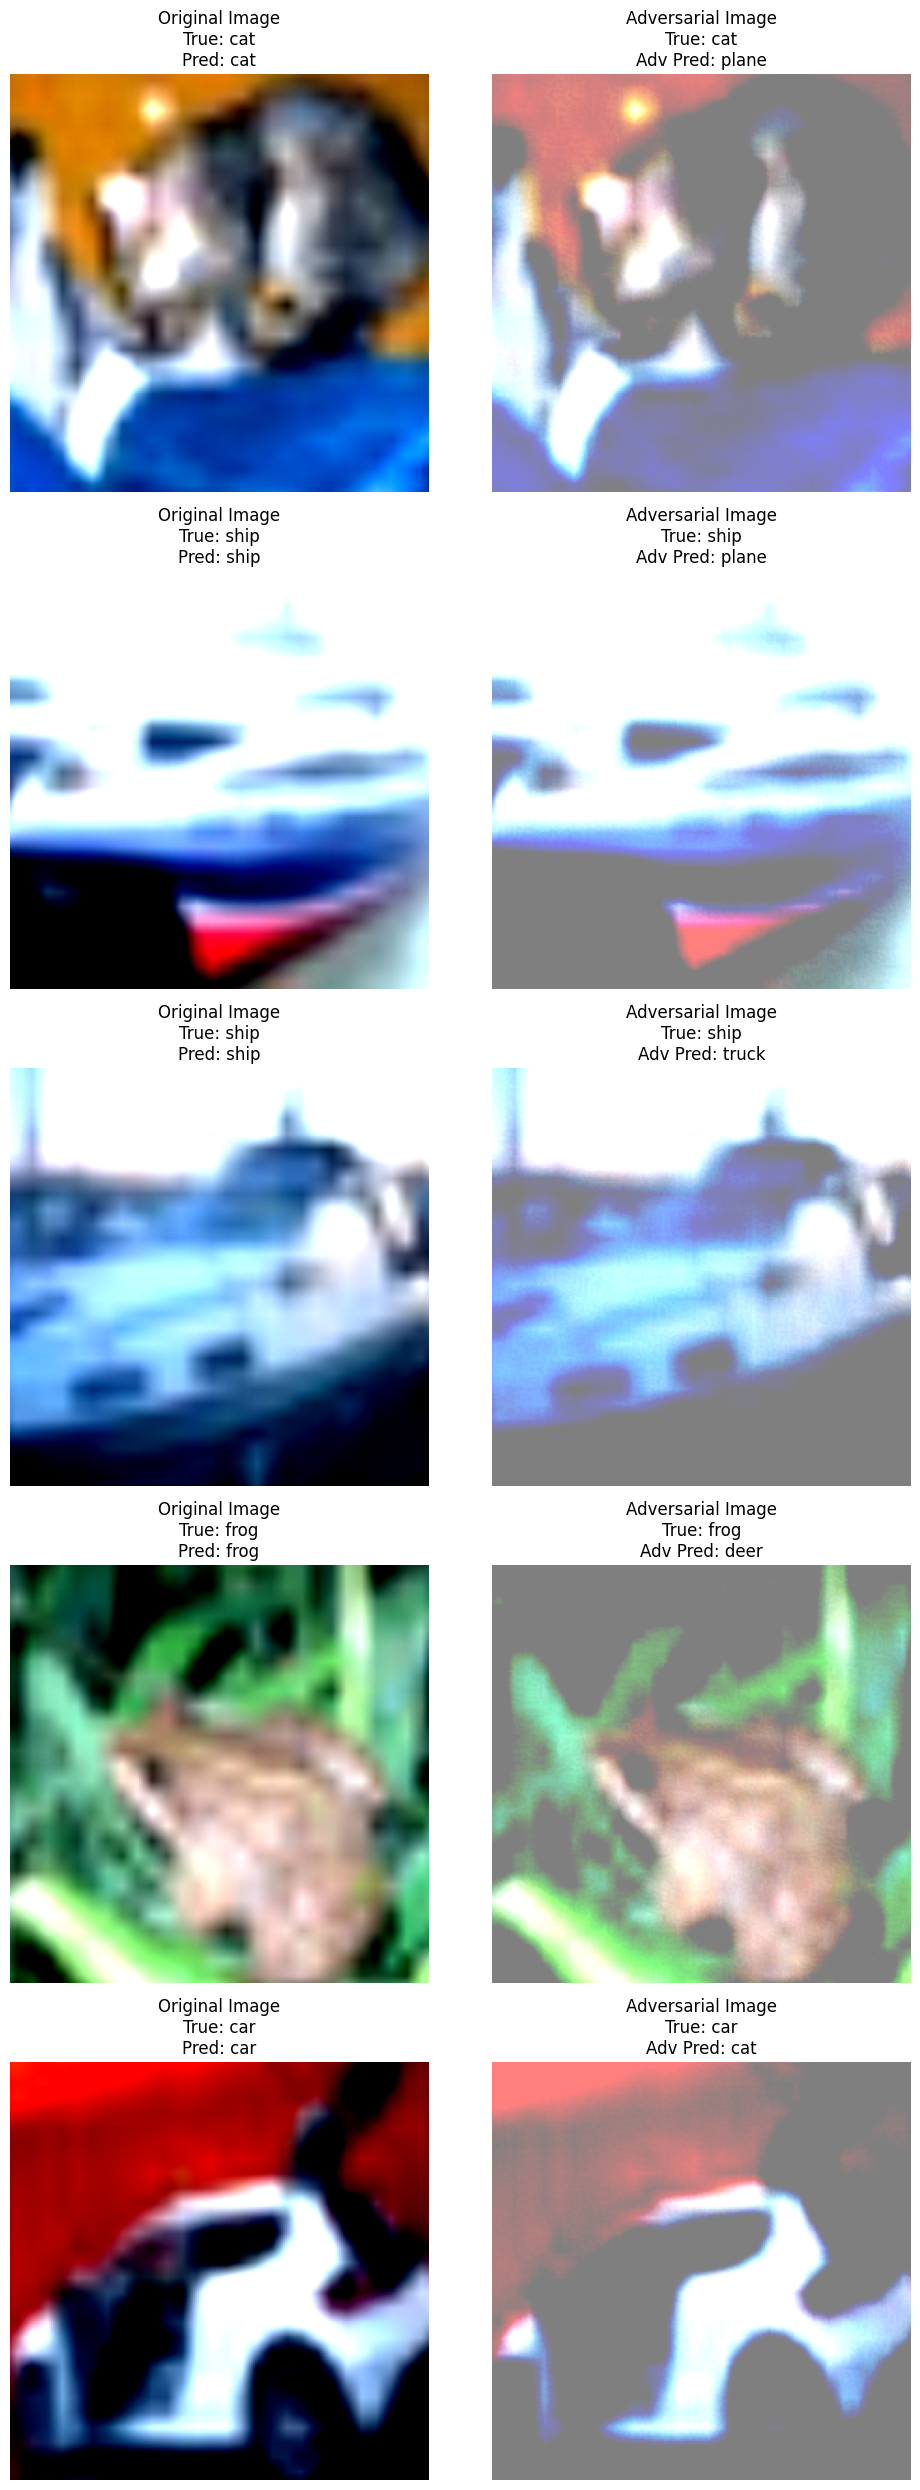

In [19]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the FGSM Attack
attack_fgsm = torchattacks.FGSM(model, eps=8/255)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_fgsm(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    # Original image
    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    # Adversarial image
    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


**VANILA Attack**

In [21]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the VANILA Attack
attack_vanila = torchattacks.VANILA(model)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_vanila(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        # Original image
        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        # Adversarial image
        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


Success Rate: 0.0000
No successful attacks to display.


**GN Attack**

Success Rate: 0.3922


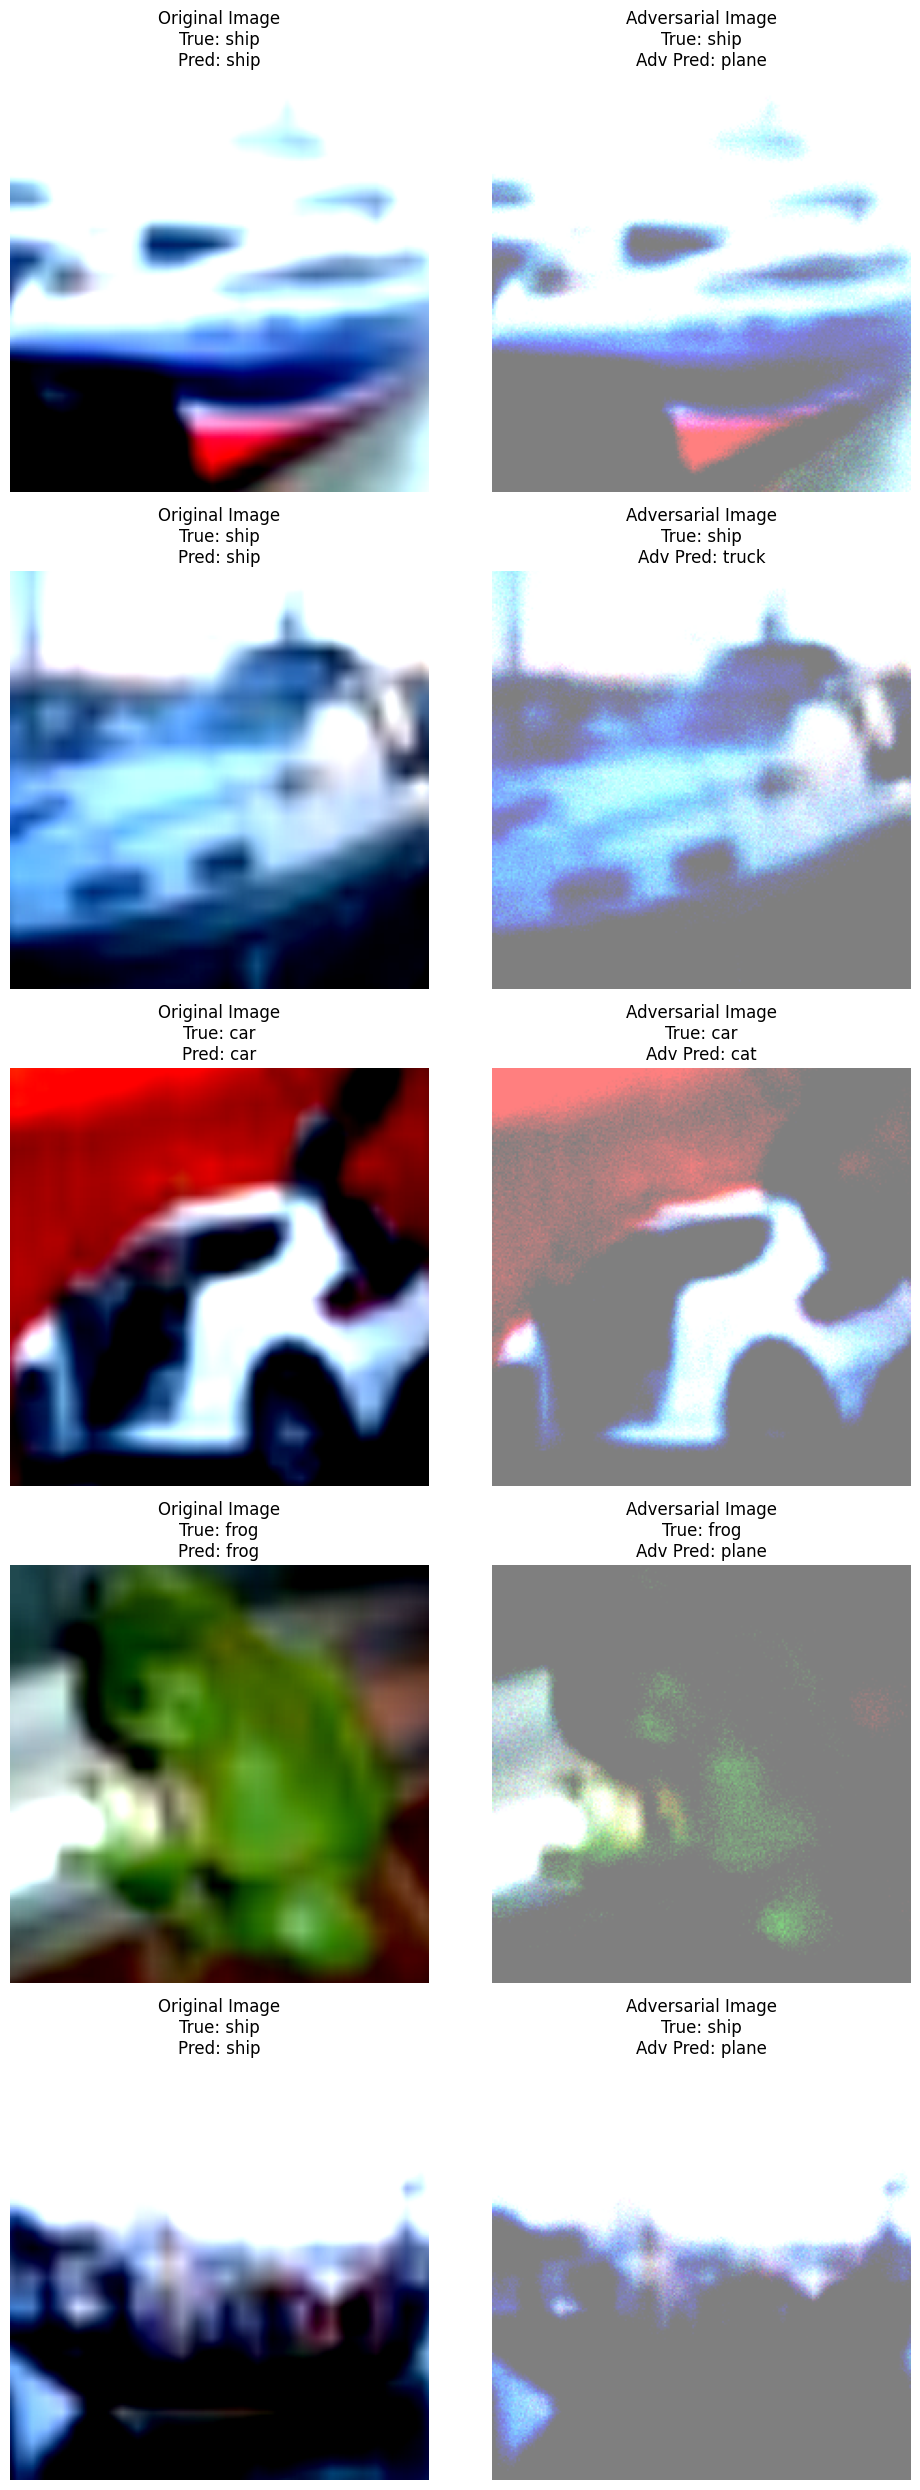

In [22]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the GN Attack
attack_gn = torchattacks.GN(model, std=0.1)

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = 0

# To store examples of successful attacks
examples = []

# Number of batches to process (subset of the test dataset)
num_batches_to_process = 10  # Adjust this number based on your performance needs

# Enable gradient computation
torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Ensure images require gradients
    images.requires_grad = True

    adv_images = attack_gn(images, labels)

    # Predictions on original and adversarial images
    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    # Compare predictions to determine if attack was successful
    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

# Disable gradient computation
torch.set_grad_enabled(False)

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print(f'Success Rate: {success_rate:.4f}')

# Visualization of some successful attack examples
num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        # Original image
        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        # Adversarial image
        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))  # Unnormalize
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


**BIM Attack**

Success Rate: 0.5781


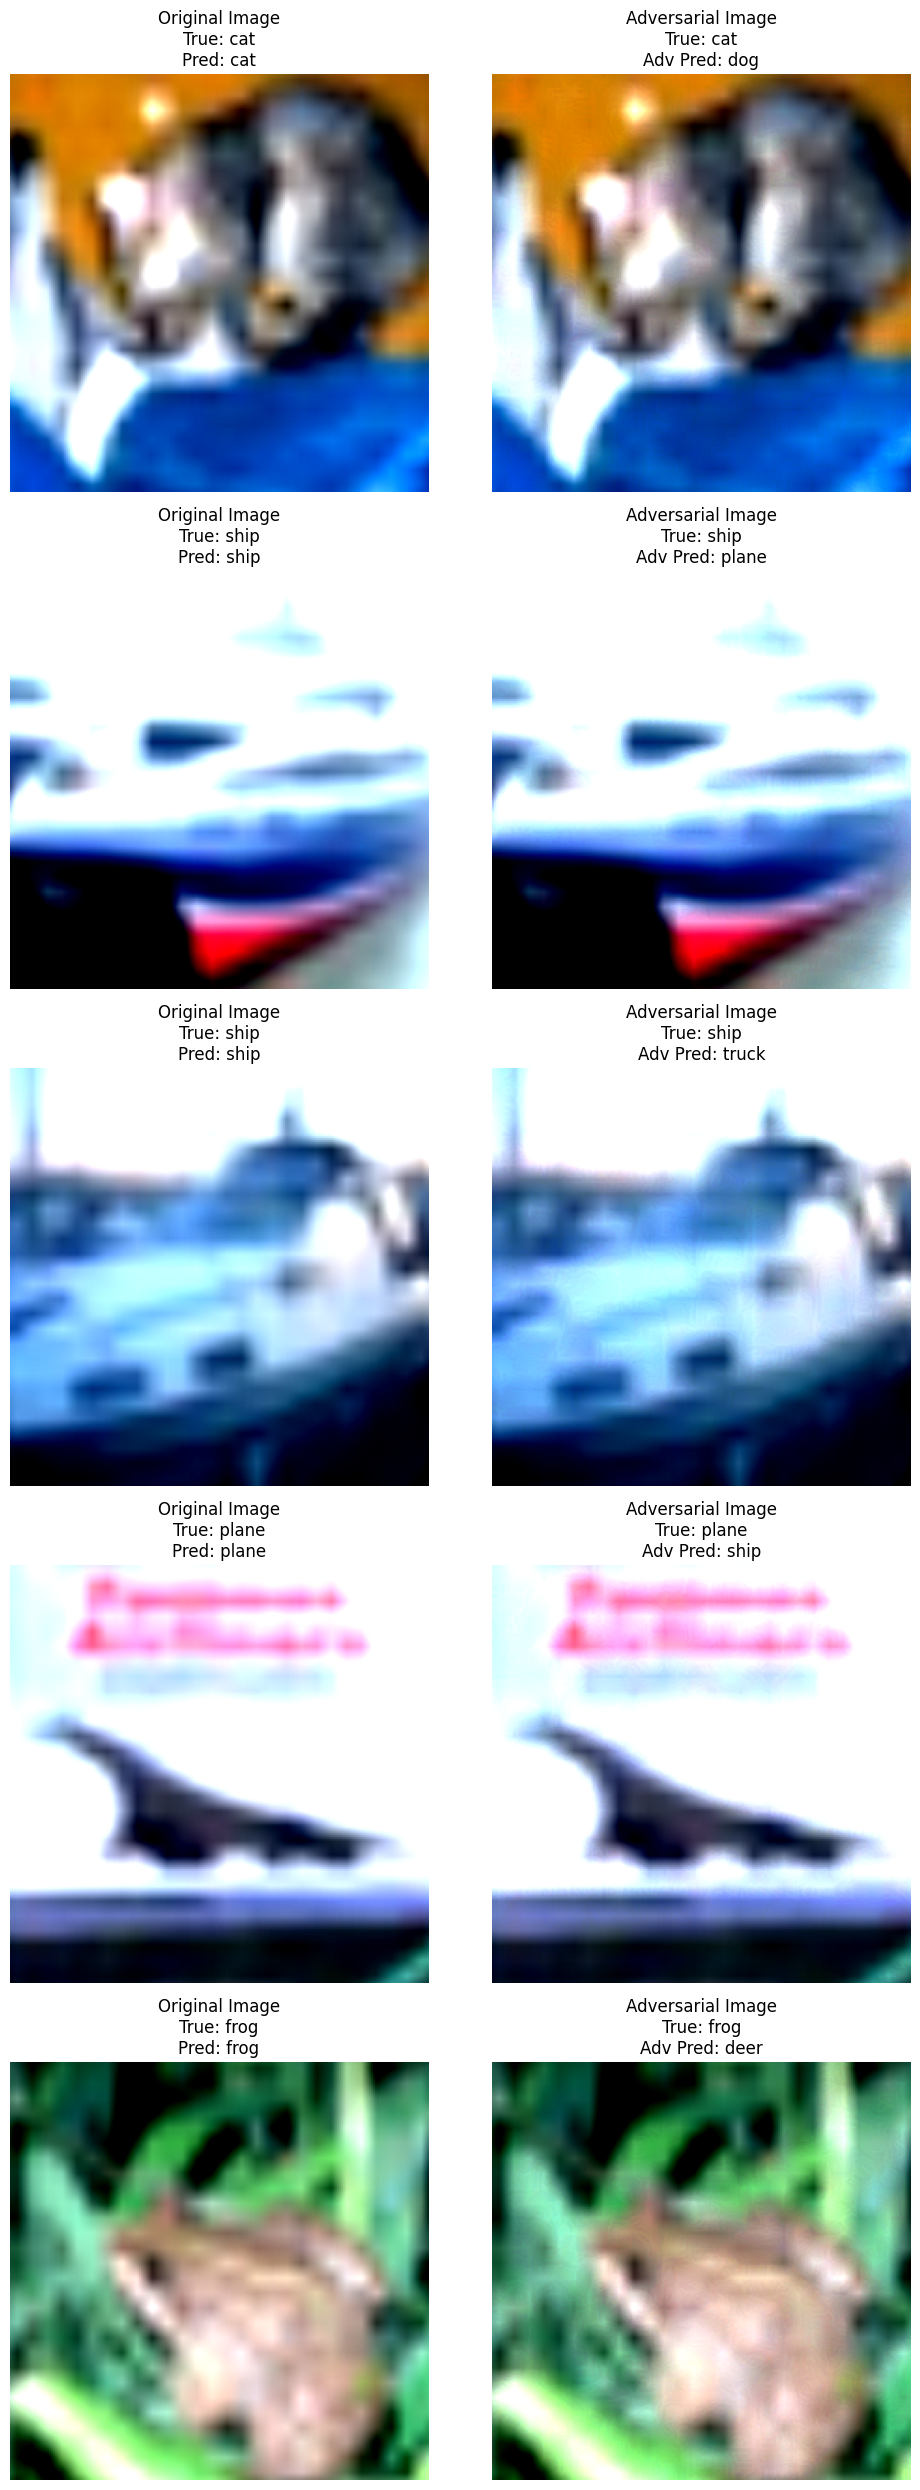

In [23]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

attack_bim = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    adv_images = attack_bim(images, labels)

    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


**Auto Attack**

Success Rate: 0.6500


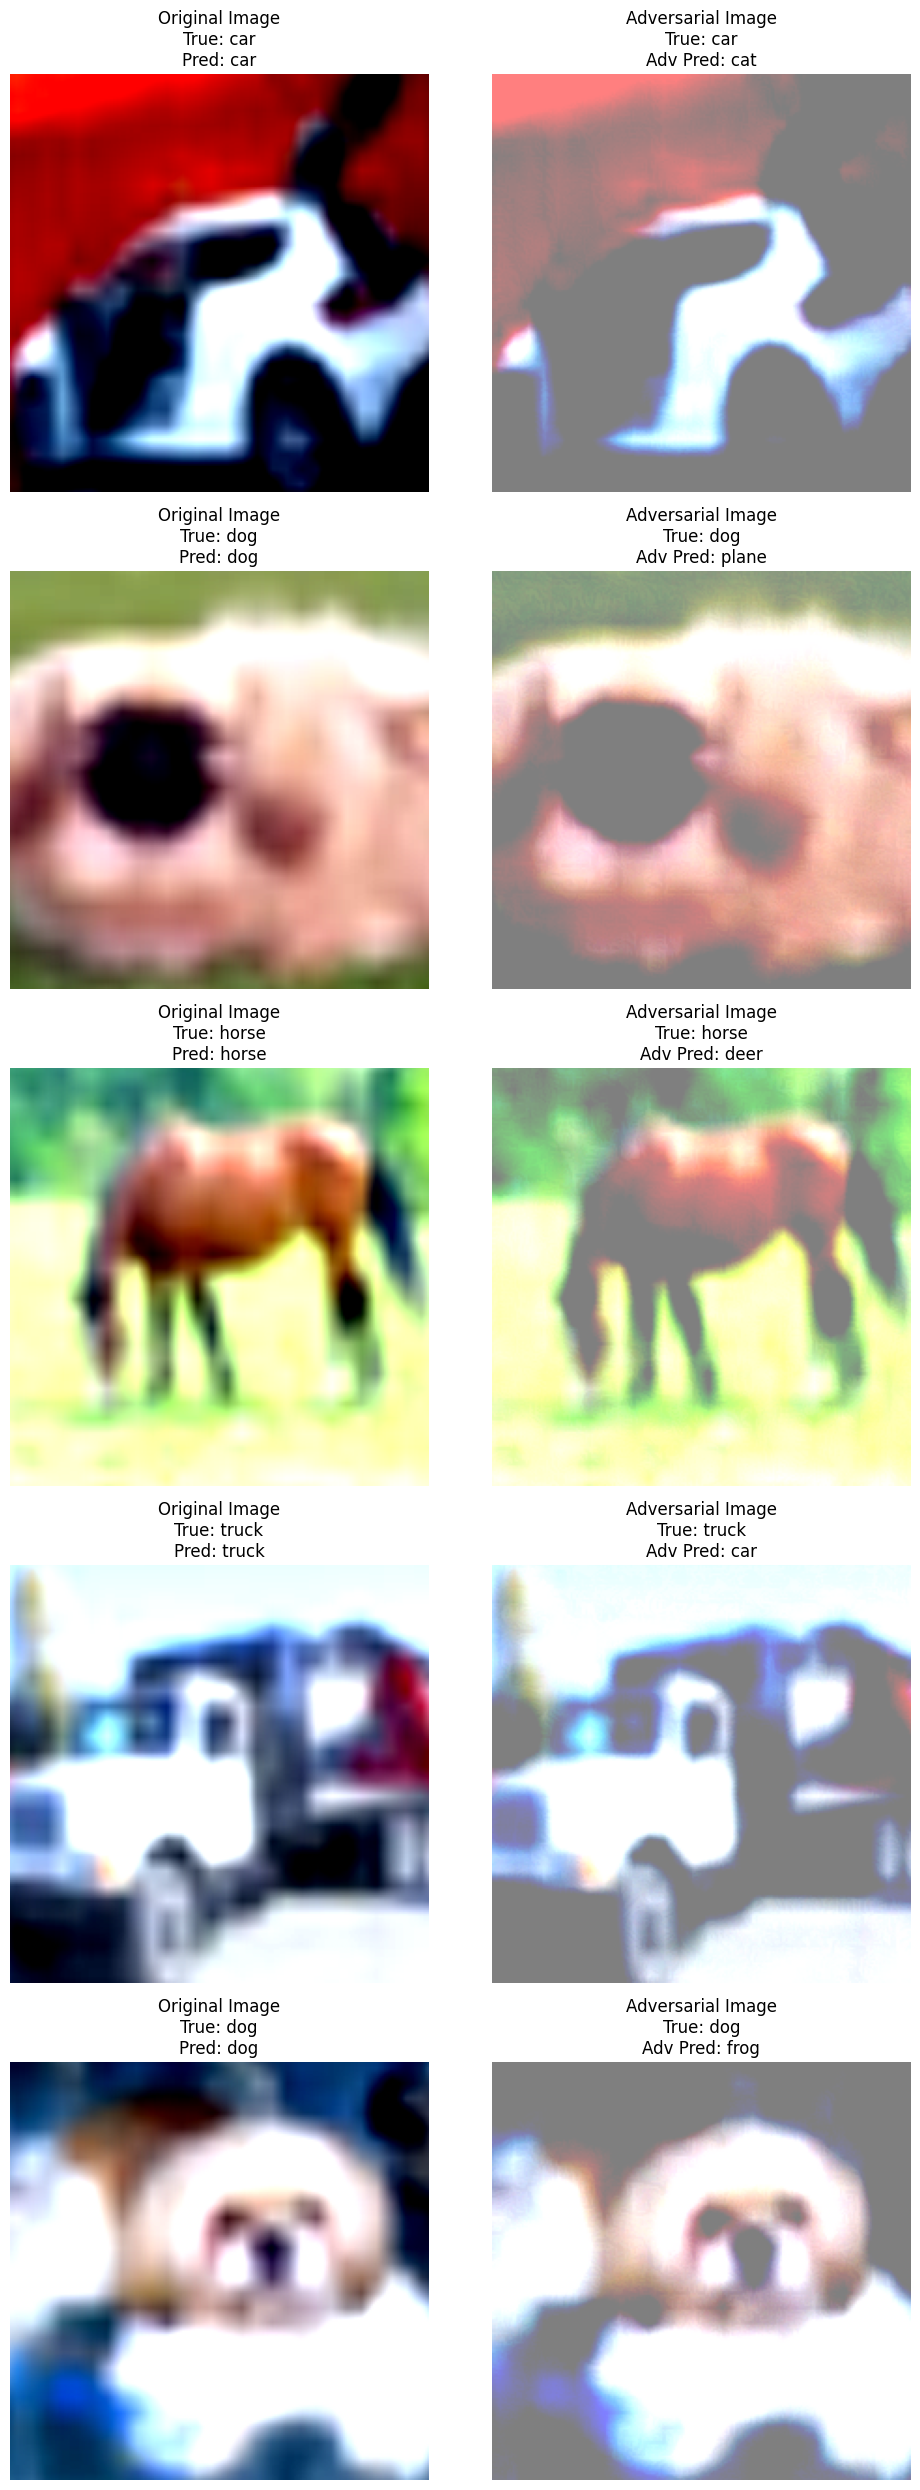

In [25]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the AutoAttack
attack_auto = torchattacks.AutoAttack(model, norm='Linf', eps=8/255, version='standard', n_classes=10)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 5  # Adjust this number to speed up processing
batch_size = 16  # Adjust batch size for faster processing

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Select a random subset of the batch
    indices = np.random.choice(images.size(0), batch_size, replace=False)
    images, labels = images[indices], labels[indices]

    images.requires_grad = True

    adv_images = attack_auto(images, labels)

    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


**Square Attack**

Success Rate: 0.6625


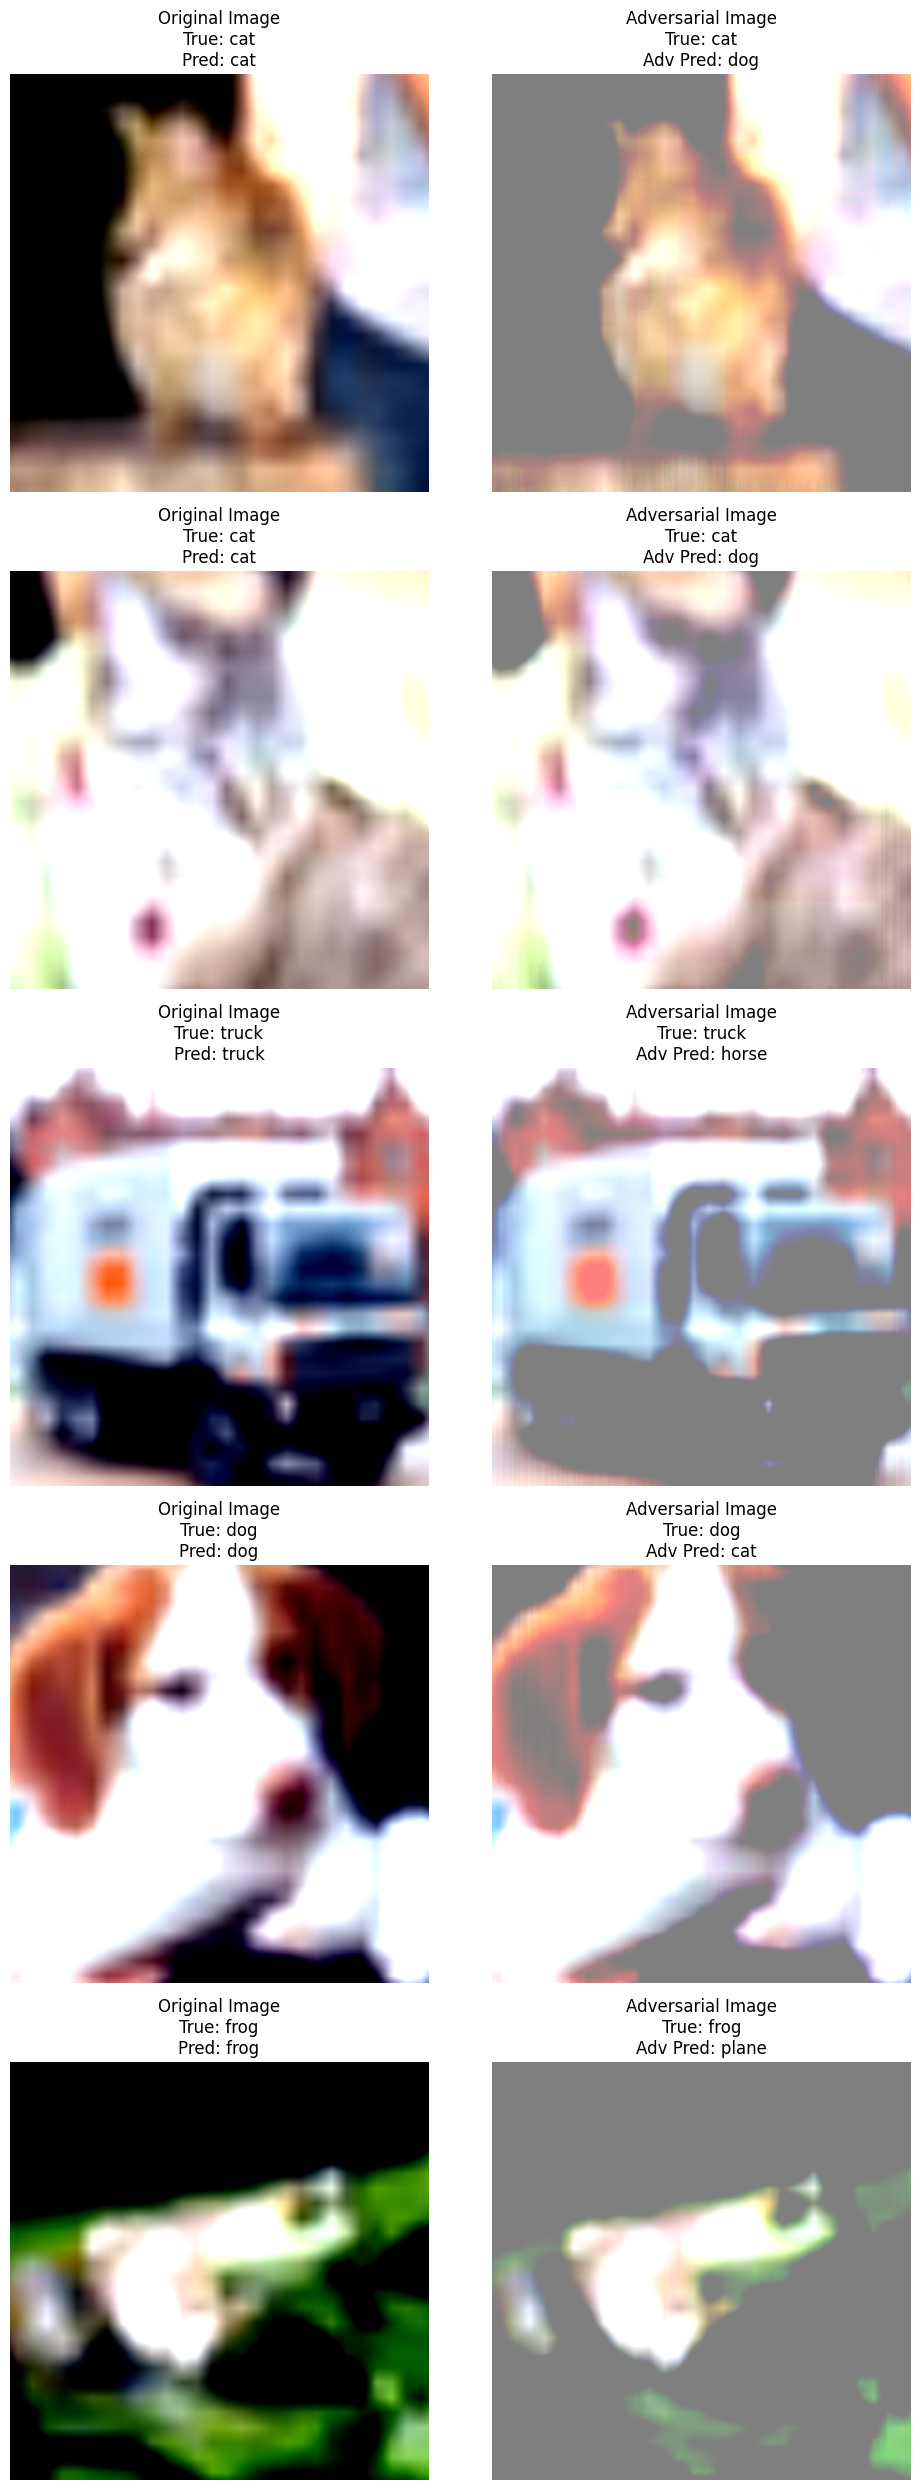

In [26]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Square Attack
attack_square = torchattacks.Square(model, norm='Linf', eps=8/255, n_queries=5000, n_restarts=1, p_init=0.8, loss='margin', resc_schedule=True, seed=0, verbose=False)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 5  # Adjust this number to speed up processing
batch_size = 16  # Adjust batch size for faster processing

torch.set_grad_enabled(True)

for batch_idx, (images, labels) in enumerate(test_loader):
    if batch_idx >= num_batches_to_process:
        break

    images, labels = images.to(device), labels.to(device)

    # Select a random subset of the batch
    indices = np.random.choice(images.size(0), batch_size, replace=False)
    images, labels = images[indices], labels[indices]

    images.requires_grad = True

    adv_images = attack_square(images, labels)

    original_predictions = model(images)
    adversarial_predictions = model(adv_images)

    original_pred_labels = torch.argmax(original_predictions, dim=1)
    adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

    for i in range(len(labels)):
        if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
            successful_attacks += 1
            examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

    total_samples += labels.size(0)

torch.set_grad_enabled(False)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
if num_examples_to_show > 0:
    fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
    for i in range(num_examples_to_show):
        original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

        axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
        axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No successful attacks to display.")


**SPSA Attack**

In [1]:
import torchattacks
import matplotlib.pyplot as plt
import numpy as np

attack_spsa = torchattacks.SPSA(model, eps=8/255, delta=0.01, lr=0.01, nb_iter=1, nb_sample=128, max_batch_size=64)

successful_attacks = 0
total_samples = 0
examples = []
num_batches_to_process = 10

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx >= num_batches_to_process:
            break

        images, labels = images.to(device), labels.to(device)
        adv_images = attack_spsa(images, labels)

        original_predictions = model(images)
        adversarial_predictions = model(adv_images)

        original_pred_labels = torch.argmax(original_predictions, dim=1)
        adversarial_pred_labels = torch.argmax(adversarial_predictions, dim=1)

        for i in range(len(labels)):
            if original_pred_labels[i] == labels[i] and original_pred_labels[i] != adversarial_pred_labels[i]:
                successful_attacks += 1
                examples.append((images[i].cpu(), adv_images[i].cpu(), labels[i].cpu(), original_pred_labels[i].cpu(), adversarial_pred_labels[i].cpu()))

        total_samples += labels.size(0)

success_rate = successful_attacks / total_samples

print(f'Success Rate: {success_rate:.4f}')

num_examples_to_show = min(5, len(examples))
fig, axs = plt.subplots(num_examples_to_show, 2, figsize=(10, 5 * num_examples_to_show))
for i in range(num_examples_to_show):
    original_image, adv_image, true_label, orig_pred, adv_pred = examples[i]

    axs[i, 0].imshow(np.transpose(original_image / 2 + 0.5, (1, 2, 0)))
    axs[i, 0].set_title(f"Original Image\nTrue: {classes[true_label]}\nPred: {classes[orig_pred]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(np.transpose(adv_image / 2 + 0.5, (1, 2, 0)))
    axs[i, 1].set_title(f"Adversarial Image\nTrue: {classes[true_label]}\nAdv Pred: {classes[adv_pred]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined